In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# building the vocabulary of charcters and mappings to integers and integer to characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3 # context length from how man y words we predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr,  ytr  = build_dataset(words[:n1])     # 80%
xdev, ydev = build_dataset(words[n1:n2])   # 10%
xte,  yte  = build_dataset(words[n2:])     #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:

n_embd = 10 # the dimensionality of the character look up we can multiply it with block size
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5) #scaling factor for tanh is 5/3 and here divide with sqrt of fanin
#b1 = torch.randn(n_hidden,                        generator=g)*0.01 no need because it has own bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 
b2 = torch.randn(vocab_size,                      generator=g)*0  # multiply with 0 to reduce the logits value closer to 0
#batchnorm parameters
bngain=torch.ones(1,n_hidden) 
bnbias=torch.zeros(1,n_hidden) # has its own bias
bnmean_running=torch.zeros(1,n_hidden)
bnstd_running=torch.ones(1,n_hidden)
parameters = [C, W1, W2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True #it keep tracks the gradient

12070


In [8]:
# using xtr and ytr
max_steps=200000
batch_size=32 #using  minibatch
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator = g) #mini batch constructed
    xb,yb=xtr[ix],ytr[ix]
    emb=C[xb] #32,3,10
    embcat=emb.view(emb.shape[0],-1) #in -1 pytorch automatically assigns the value
    hpreact=embcat @ W1 #+b1  #hidden layer pre activation
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*(hpreact-bnmeani)/bnstdi+bnbias #batch normalization layer has bnbias in own so no need to add ext bias
    with torch.no_grad():
         bnmean_running=0.999*bnmean_running+0.001*bnmeani #these are inferences used for the testing and validatiio after the completion of training
         bnstd_running=0.999*bnstd_running+0.001*bnstdi
    h=torch.tanh( hpreact)
    logits=h @ W2 #+b2
    loss=F.cross_entropy(logits,yb)# loss function

    #backward pass 
    for p in parameters:
         p.grad=None
    loss.backward()
    #update
    lr=0.1 if i<10000 else 0.01
    for p in parameters:
         p.data+=-lr*p.grad
    if i%10000==0:
         print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:3.3239


In [32]:
yb.shape

torch.Size([32])

In [10]:
bngain*(hpreact-bnmeani)/bnstdi+bnbias 

tensor([[-0.5829,  0.9520,  1.1025,  ...,  0.1296,  0.2027, -0.2519],
        [ 0.0815, -0.5975,  0.2144,  ..., -0.4118, -0.3383, -0.6826],
        [ 0.9835, -0.5265,  0.4795,  ..., -0.4433, -0.6783, -0.4986],
        ...,
        [ 0.4037,  0.2982,  0.8995,  ..., -0.5717,  0.1707,  0.2006],
        [-0.5829,  0.9520,  1.1025,  ...,  0.1296,  0.2027, -0.2519],
        [ 0.5072,  1.5797,  0.8295,  ..., -0.6011,  0.3602, -0.5761]],
       grad_fn=<AddBackward0>)

In [11]:
torch.randint(0,xtr.shape[0],(batch_size,),generator = g)

tensor([ 66283,  55537,  93212, 114746,  88746, 119335,  87986, 107572, 118109,
        170392, 112663,  61513,  30511, 166981,  53356,   3617, 175087, 151013,
        130704, 100241,  23697, 128793,  18947, 134923, 158443, 158801, 104705,
        110635, 127701,  13478,  85264, 165063])

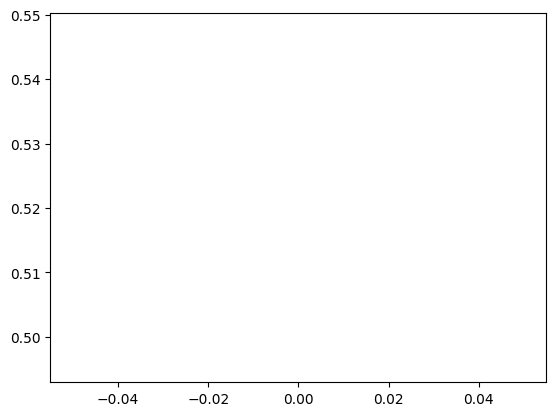

In [12]:
plt.plot(lossi)

In [13]:
logits[0]

tensor([-0.0466,  0.0713,  0.0408,  0.0311,  0.0199, -0.0039, -0.0263,  0.0528,
         0.0117, -0.0337, -0.1020, -0.1050,  0.0434,  0.0396,  0.0409, -0.0494,
         0.0589, -0.0159,  0.0335, -0.0671,  0.1769,  0.1197,  0.0399, -0.0758,
         0.0124,  0.1491,  0.0106], grad_fn=<SelectBackward0>)

In [14]:
#Saturated-when the act func produces output very close to the input values
#non linearity is function where output change does not directly propotional to input
#when we use relu it destroys half in the negative site , to compensate this with a gain we use sd=sqrt(2/N_in)(using kaiming init techniq for weight adjustment)
#formula for weigt adjusment in tanh ==gain/sqrt(fanin)
#A Gaussian distribution with zero mean and controlled variance ensures weights stay in a balanced range.(for relu and tanh)
#in batch normalization reduce the loss by adjusting the mean and variance across a mini batch
#have a screenshot for formulas normalize the hidden hpreact layer using gaussian distribution

In [15]:
torch.no_grad() #this disables gradient tracking
emb=C[xtr] #(N,blocksize,n_embd)
embcat=emb.view(emb.shape[0],-1) #concat with (N,blocksize* n_embd)
hpreact=embcat @ W1 #b1 #N,n_hidden 
bnmean=hpreact.mean(0,keepdim=True)
bnstd=hpreact.std(0,keepdim=True)
# hpreact=bngain*(hpreact-(hpreacbngain*(hpreact-bnmeani)/bnstdi+bnbias #t.mean(0,keepdim=True)))/hpreact.std(0,keepdim=True)+bnbias

In [16]:
@torch.no_grad() #this disables gradient tracking
def split_loss(split):
    x,y={ 
    'train' : (xtr,ytr),
    'val' : (xdev,ydev),
    'test': (xte,yte),
    }[split] # it takes the train and val string in the list
    emb=C[x] #(N,blocksize,n_embd)
    embcat=emb.view(emb.shape[0],-1) #concat with (N,blocksize* n_embd)
    hpreact=embcat @ W1  #b1 #N,n_hidden 
    hpreact=bngain*(hpreact-bnmeani)/bnstdi+bnbias
    h=torch.tanh( hpreact)
    logits=h @ W2 +b2
    loss=F.cross_entropy(logits,y)# loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 3.260741949081421
val 3.2603137493133545


In [17]:
hpreact.shape

torch.Size([182625, 200])

In [18]:
# loss 
#  fix softmax confidently wrong---->
# train 2.1446988582611084
# val 2.1785755157470703
#fix tanh layer saturated at init------>
# train 2.100076198577881
# val 2.1391818523406982
#use semi principled kaiming init instead of hacky init(ie multiply the weight by gain divided by sqrt(fanin))
# train 2.0994210243225098
# val 2.1359660625457764
#Add a batch norm layer


In [19]:
#  plt.hist(h.view(-1).tolist(),50); #tanh doesn't affect the loss because it is a flat surface(refer tanh backward in micrograd)

In [20]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99,cmap='grey',interpolation='nearest')
#in 200 colums if one row is fully white (i.e) true is dead neuron and does not learn anything

In [21]:
# plt.hist(hpreact.view(-1).tolist(),50);

In [22]:
(torch.rand(1000)*0.2).std()

tensor(0.0576)

tensor(-0.0017) tensor(0.9963)
tensor(7.2449e-05) tensor(1.0045)


(array([2.11488412e-05, 2.11488412e-05, 2.11488412e-05, 0.00000000e+00,
        2.11488412e-05, 6.34465236e-05, 2.53786094e-04, 3.59530300e-04,
        4.86423347e-04, 6.13316395e-04, 9.09400171e-04, 2.36867021e-03,
        3.15117734e-03, 5.87937785e-03, 9.00940635e-03, 1.51848680e-02,
        2.49344838e-02, 3.88715701e-02, 6.12893418e-02, 9.11938032e-02,
        1.32772425e-01, 1.79870894e-01, 2.43951883e-01, 3.07631044e-01,
        3.71965819e-01, 4.08955142e-01, 4.24330350e-01, 4.06586472e-01,
        3.66763204e-01, 3.11987705e-01, 2.44036478e-01, 1.83952621e-01,
        1.32603234e-01, 9.14898870e-02, 6.28332072e-02, 3.96752261e-02,
        2.56323955e-02, 1.52271657e-02, 9.98225304e-03, 5.66788944e-03,
        4.14517287e-03, 2.49556326e-03, 1.05744206e-03, 5.71018712e-04,
        3.38381459e-04, 2.96083777e-04, 1.05744206e-04, 4.22976824e-05,
        1.05744206e-04, 4.22976824e-05]),
 array([-6.26894808, -6.03252851, -5.79610893, -5.55968936, -5.32326979,
        -5.08685021, 

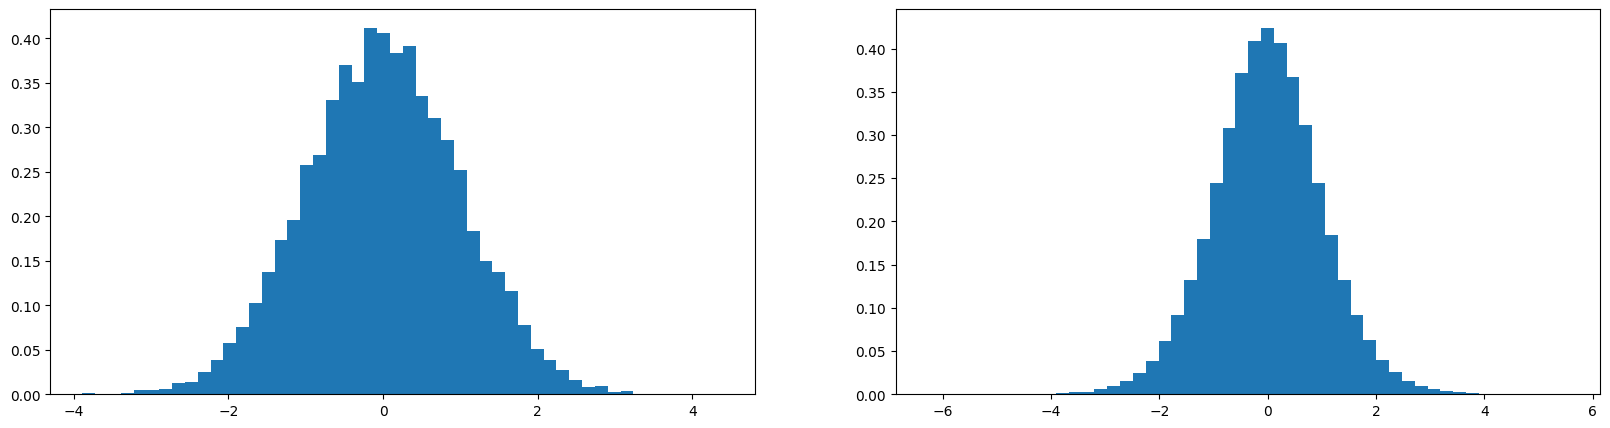

In [23]:
x=torch.randn(1000,10)
w=torch.randn(10,200) /10**0.5
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=[20,5])
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)


In [24]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained using back propagation they are learnable)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    #forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): #they are not going to compute gradients
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 #  dimension of the character embedding vectors C
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),#list of layers in the deep neural network
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0#5/3 gain to compensate the flat surface

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True #default value is false

47024


In [25]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, xtr.shape[0], (batch_size,), generator=g)
  xb, yb = xtr[ix], ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() #would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # updating
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track status
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    break


      0/ 200000: 3.2870


In [26]:
emb.shape

torch.Size([32, 3, 10])

layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.69%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%


Text(0.5, 1.0, 'activation distribution')

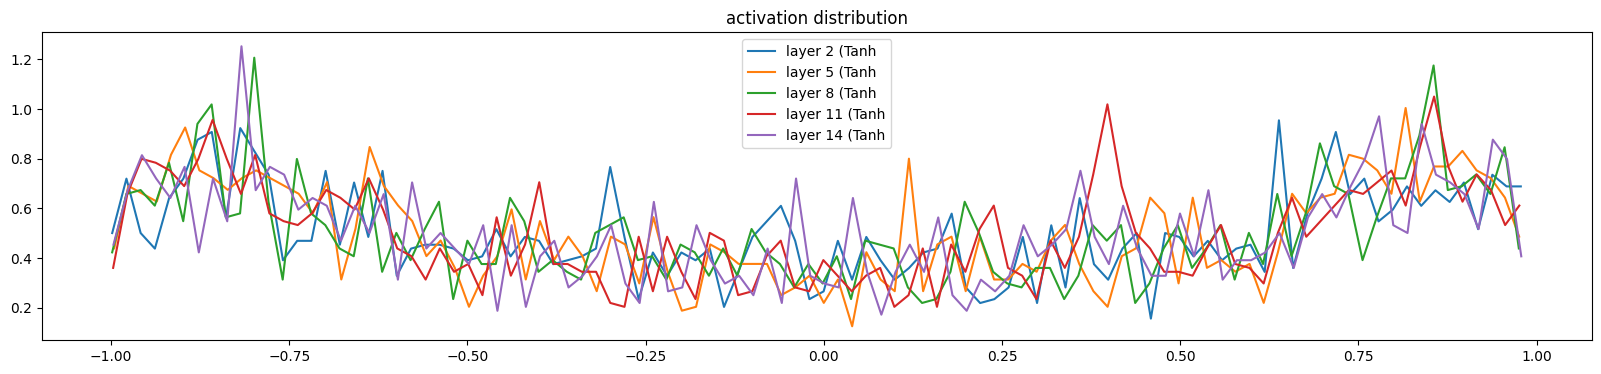

In [27]:


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')



layer 2 (      Tanh): mean -0.000000, std 8.981606e-04
layer 5 (      Tanh): mean -0.000000, std 7.436656e-04
layer 8 (      Tanh): mean +0.000000, std 6.661792e-04
layer 11 (      Tanh): mean +0.000000, std 5.511524e-04
layer 14 (      Tanh): mean -0.000000, std 4.804411e-04


Text(0.5, 1.0, 'gradient distribution')

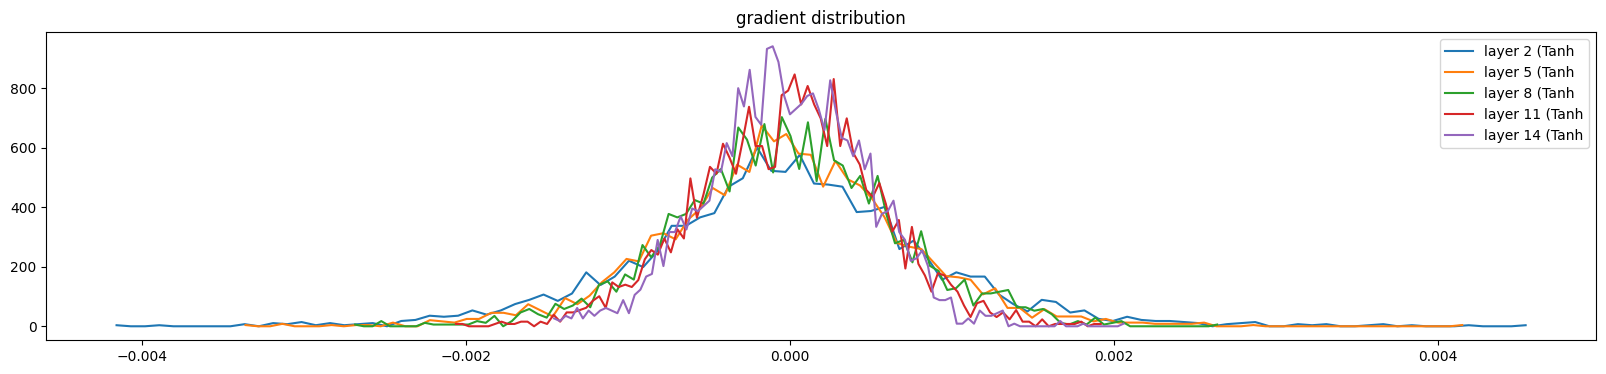

In [28]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.623013e-03 | grad:data ratio 1.621839e-03
weight  (30, 100) | mean -0.000079 | std 2.927976e-03 | grad:data ratio 1.564774e-02
weight (100, 100) | mean +0.000019 | std 2.756765e-03 | grad:data ratio 2.765819e-02
weight (100, 100) | mean -0.000029 | std 2.474042e-03 | grad:data ratio 2.456095e-02
weight (100, 100) | mean -0.000022 | std 2.213402e-03 | grad:data ratio 2.206582e-02
weight (100, 100) | mean -0.000018 | std 1.916712e-03 | grad:data ratio 1.908954e-02
weight  (100, 27) | mean +0.000006 | std 3.330992e-03 | grad:data ratio 3.369028e-02


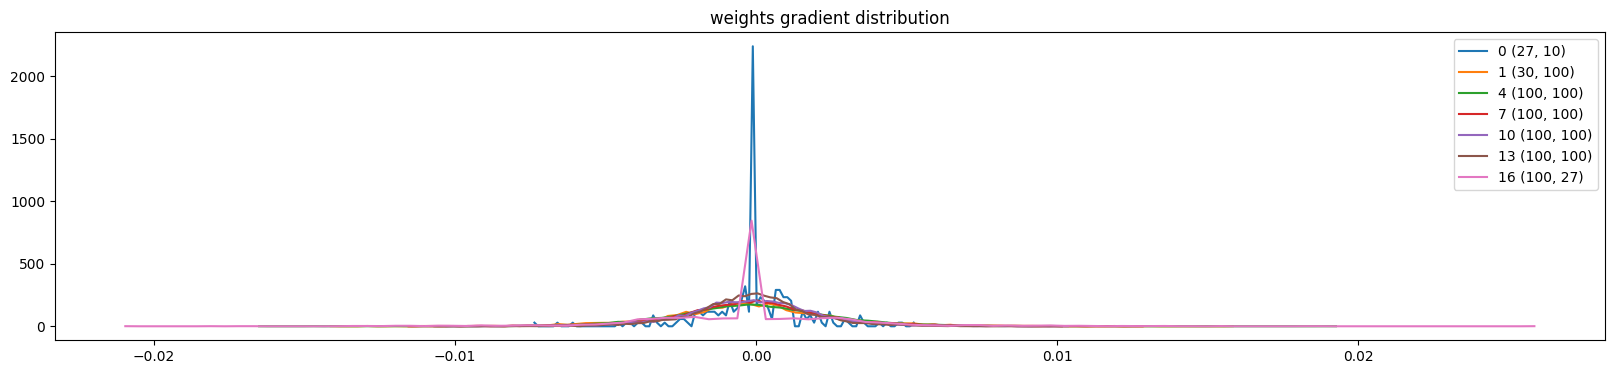

In [ ]:
brn
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

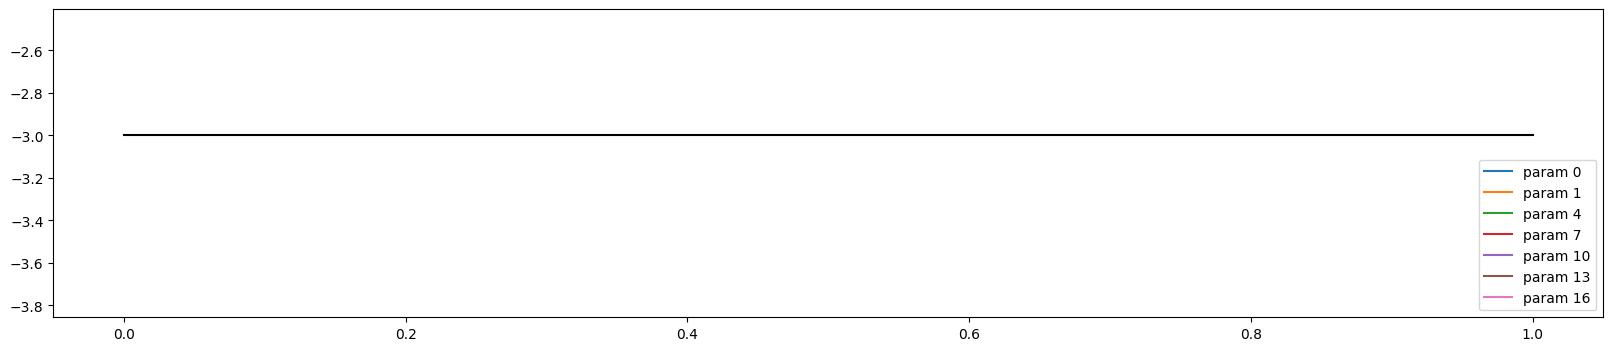

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);